Notebook version 1.0, 31 Aug 2021. Written by Joona Andersson / CSC - IT Center for Science Ltd. joona.andersson77@gmail.com

Licensed under the MIT license: http://www.opensource.org/licenses/mit-license.php
***
# Shor's Circuit Conversion for Shor's Algorithm
The aim of this notebook is to convert the general Shor's circuit for factorizing 15 to a circuit which can be run on an existing quantum processor. For this purpose we've chosen IBM's Dublin processor. There exists a shorter version of the Shor circuit that uses only 7 qubits, but here the aim is to demonstrate how the algorithm scales up using current hardware when more qubits are needed.  <br>
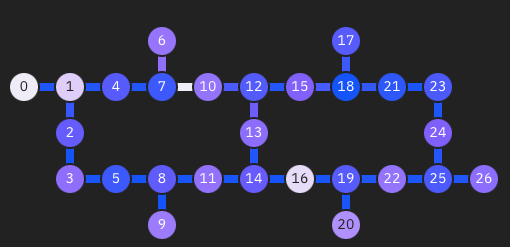
We won't need to utilize the entire topology of the processor, since our circuit uses only 12 qubits. The conversion itself will be done in two parts. First, we have to convert the gates of the general circuits into gates that are native to the processor, and we must make sure that each gate only uses at the most two qubits. This is achieved by decomposing gates. Next, we must make sure the circuit follows the topology of the Dublin processor. We can use the Nnizer plugin for this. <br>

Finally, we will perform a noise simulation on the circuit obtained after the conversion to see if it could be used in practice.

In [ ]:
## Import general libraries
from qat.lang.AQASM import *
from qat.lang.AQASM.qftarith import QFT
import qat.lang.AQASM.qftarith as qftarith
import numpy as np
from qat.qpus import LinAlg
from qat.core.util import statistics  ## this will tell us the number of specific gates in the circuit
import matplotlib.pyplot as plt
import time

In [ ]:
## A sub-routine used in the general circuit
def c_mult_mod15(power): # Controlled multiplication by a mod 15
    rout = QRoutine() # Use QRoutine to create a circuit generator
    wires = rout.new_wires(4)
    for _ in range(power):
        # We are reeplacing SWAP gates with CNOTs here it is much easier to implement circuit conversion
        # without having to replace controlled-SWAP gates
        rout.apply(CNOT, wires[0], wires[1])
        rout.apply(CNOT, wires[1], wires[0])
        rout.apply(CNOT, wires[0], wires[1])
      #--------------------------------------
        rout.apply(CNOT, wires[1], wires[2])
        rout.apply(CNOT, wires[2], wires[1])
        rout.apply(CNOT, wires[1], wires[2])
      #--------------------------------------
        rout.apply(CNOT, wires[2], wires[3])
        rout.apply(CNOT, wires[3], wires[2])
        rout.apply(CNOT, wires[2], wires[3])
    return rout
#Turn the circuit into a custom gate that we can apply later
c_mod15_gate = AbstractGate('Mod15',  [int], circuit_generator=c_mult_mod15)

In [ ]:
## Build general circuit
N = 15
a = 2
n = N.bit_length()

shor = Program()
qbits = shor.qalloc(12)
for q in range(n*2):
    shor.apply(H, qbits[q])
shor.apply(X, qbits[11])
for q in range(2*n):
    shor.apply(c_mod15_gate(2**q).ctrl(), qbits[q], qbits[n*2:])
shor.apply(QFT(n*2).dag(), qbits[:n*2])
circuit = shor.to_circ()
%qatdisplay circuit
## Display the statistics of the general circuit
print(statistics(circuit))

## Circuit Conversion Part 1 - Decomposing Gates
The quantum operations native to the selected processor are the following: CX, ID, RZ, SX, X. However, as seen above, the general circuit uses gates that are not included in the native operations. We can replace these operations using gate decomposition rules and the GraphCircuit class.

In [ ]:
## Import GraphCircuit
from qat.pbo import GraphCircuit

# Generate a graph, i.e. a representation of circuit that can be modified/optimized
graph = GraphCircuit()

# Transform the original circuit in to a graph
graph.load_circuit(circuit)
qubits = [0,1,2,3,4,5,6,7,8,9,10,11] ## a list of qubit indeces

In [ ]:
## Decompostion rules

# Decomposes the X gate into two RX rotations
def X_rule(i):
    return [('X',[i])],[('RX',[i],np.pi/2),('RX',[i],np.pi/2)] 

# The Hadamard can be decomposed similarly
def H_rule(i):
    return [('H',[i]),],[('RZ',[i],np.pi/2),('RX',[i],np.pi/2),('RZ',[i],np.pi/2)]

Next, we define functions to replace controlled CNOT gates (Toffoli) and the controlled PH gates according to the following patterns.
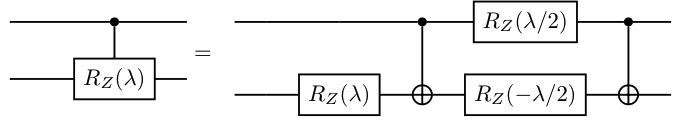 <br>
Controlled PH gate decomposition where $\lambda$ is the desired angle of rotation.
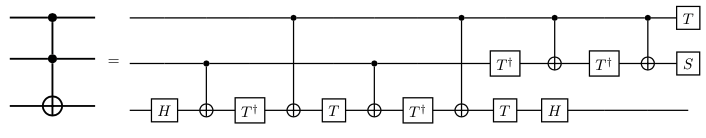
Toffoli gates can be decomposed to two-qubit gates with a minimum of six CNOTs.

In [ ]:
# PH is just a Z rotation for some arbitrary angle. The controlled version C-PH can be decomposed with
# the help of the CNOT gate.
def replace_C_PH(graph):
    angles = [-np.pi/2, -np.pi/4, -np.pi/8, -np.pi/16, -np.pi/32, -np.pi/64, -np.pi/128]
    for angle in angles:
        graph.replace_pattern([('C-PH', [0, 1], angle)],
                                        [('RZ', [1], angle/2),
                                         ('CNOT', [0, 1]),
                                         ('RZ', [1], -angle/2), 
                                         ('RZ', [0], angle/2)], pos=all)
# The controlled CNOT or the Toffoli gate is difficult to implement physically, but it can also be decomposed
# using CNOT gates together with Hadamards and T gates. Note that the T gate is simply a Z rotation with an
# angle of pi/4.
def replace_CCNOT(graph):
    graph.replace_pattern([('C-CNOT', [0, 4, 5])],
                        [('H', [5]), ('CNOT', [4, 5]), ('D-T', [5]), ## D-T == T dagger
                         ('CNOT', [0, 5]), ('T', [5]),
                         ('CNOT', [4, 5]), ('D-T', [5]),
                         ('CNOT', [0, 5]), ('T', [5]), ('H', [5]),
                         ('T', [4]), ('CNOT', [0,4]), ('D-T', [4]),
                         ('CNOT', [0,4]), ('T', [0])], pos=all)
    

In [ ]:
# SWAP gates are later added to the circuit by Nnizer. They are easy to decompose using three CNOTs.
def replace_SWAP(graph):
    graph.replace_pattern([('SWAP', {2, 1})],
                          [('CNOT', [1, 2]),
                           ('CNOT', [2, 1]),
                          ('CNOT', [1, 2])], pos=all)
# We add so many CNOTs to the circuit that it makes sense to make sure we don't have ones that
# counter each other.
def replace_double_CNOT(graph):
    graph.replace_pattern([('CNOT', [1,2]), ('CNOT', [1, 2])], [], pos=all)

In [ ]:
## Here we perform the gate decomposition
print("Original circuit") # visualize the original circuit 
print(statistics(circuit))
print()
replace_CCNOT(graph)
for rule in [H_rule, X_rule]:                  # loop over the two pattern replacement rules.
    for i in qubits:                           # loop over all qubits of the circuit.
        while graph.replace_pattern(*rule(i)): # loop over and apply replace_pattern(old, new) to all instances 
            continue 
replace_C_PH(graph)
converted_circ = graph.to_circ()
print("Circuit conversion done")
print(statistics(converted_circ))

Decomposing the origal gates into operations that can be performed on the processor has already added a significant amount of operations to the circuit.

## Circuit Conversion Part 2 - Topology Constraints
So far we've decomposed the quantum operations down to the native ones that can be executed on the processor. However, we have not taken into account the connectivity of the qubits which is important since our circuit currently uses roughly 14 000 CNOTs. There exists a plugin called Nnizer that takes care of this problem by adding SWAP gates into the circuit.

In [ ]:
# Import tools needed for fixing connectivity issues
from qat.core.wrappers.hardware_specs import Topology, HardwareSpecs
from qat.comm.hardware.ttypes import TopologyType
from qat.plugins import Nnizer
from qat.core import Batch 

## Generate a topology object and set it to be directed; qubits can be limited 
## to being only targets or controls for conditional 2-qubit gates 
topo = Topology(is_directed=True)

# Define connections in the topology. First control and then the target qubit 
connections = [(0,1), (1,4), (1,2), (1,0), (2,3), (2, 1), (3,5), (3,2), (4, 7),
              (4, 1), (5, 8), (5, 3), (6, 7), (7, 10), (7, 4), (7,6), (8, 5), (8, 11),
              (8, 9), (9, 8), (10, 7), (11, 8)]

for ctrl, trgt in connections:
    topo.add_edge(ctrl, trgt)
# Define the hardware specs of the QPU, i.e., number of its qubits and their topology. 
hw_specs = HardwareSpecs(nbqbits=12, topology=topo)

# Generate nnizer that uses the 'atos' method to solve the connectivity constraints problem
nnizer = Nnizer(method='atos')

# We create a batch storing the converted circuit by using the compile() method 
# that takes the circuit (as batch) and the specific hardware specs as input
job = converted_circ.to_job()
nnized_batch = nnizer.compile(Batch(jobs=[job]),hw_specs) 

# the converted circuit is received from the job inside the batch and displayed
nnized_circ = nnized_batch.jobs[0].circuit
## Nnizer adds SWAP gates to the circuit which need to be replaced by CNOTs.
graph_2 = GraphCircuit()
graph_2.load_circuit(nnized_circ)
replace_SWAP(graph_2)
final_circ = graph_2.to_circ()
print(statistics(final_circ))

## Noise simulation
After the full circuit conversion we have roughly 25x the number of gates we had in the general implementation, the vast majority CNOTs. This is not ideal because the CNOT gates are hard to implement physically, and the time required to perform one CNOT is generally much longer than simple one-qubit rotations. <br>

Here we attempt to show how much individual gate errors and environmental noise affect the processor-specific Shor's algorithm.

In [ ]:
from qat.quops import QuantumChannelKraus
from qat.hardware.default import HardwareModel
from qat.qpus import NoisyQProc
from qat.quops import ParametricPureDephasing, ParametricAmplitudeDamping
from qat.hardware import GatesSpecification
from itertools import product

# X rotation gate
Xrot_fidelity = 0.995 # probability of success
Xrot_time = 30 # gate duration in nanoseconds

# Z rotation gate
Zrot_fidelity = 0.99 # probability of success
Zrot_time = 30 # gate duration in nanoseconds

# CNOT gate
CNOT_fidelity = 0.99 # probability of success
CNOT_time = 280 # gate duration in nanoseconds

# T gate
T_fidelity = 0.99
T_time = 30

## Environmetal noise parameters as reported by IBM (average values)
T1 = 120000 # qubit's energy relaxation time in nanoseconds
T2 = 190000 # qubit's dephasing time in nanoseconds

**The problem with the current hardware becomes evident** here. The T1 and T2 times are way too low comparing to the gate time (of the CNOT) multiplied by the number of required operations. The estimated execution time of the quantum part of the algorithm is roughly 13 million nanoseconds which is **two orders of magnitude larger than T1 and T2**. Quantum error correction could will fix this problem when quantum prosessors have enough qubits to implement error correction.

In [ ]:
## Defining imperfect gates and Quantum channels. Here we assume that if the gate operation fails,
## nothing happens, as opposed to a rotation with the wrong angle, for example.

px = Xrot_fidelity # probability that the RX(pi/2) rotation succeeds
noisy_RX = QuantumChannelKraus([np.sqrt(px)*np.array([[1, -1j],
                                                     [-1j, 1]])/np.sqrt(2), # the RX(pi/2) gate -> gate succeeds
                                       np.sqrt(1-px)*np.identity(2)],       # the identity -> nothing happens
                                       name="noisy RX(pi/2)")               # name of the quantum operation/channel

# Noisy pi/2 radians Z rotation. Let's make this similar to the X rotation
pz = Zrot_fidelity # probability that the RZ(pi/2) rotation succeeds
noisy_RZ = QuantumChannelKraus([np.sqrt(pz)*np.array([[1, 0],
                                                      [0, 1j]]), # the RZ(pi/2) gate -> gate succeeds
                                      np.sqrt(1-pz)*np.identity(2)],    # the identity -> nothing happens
                                       name="noisy RZ(pi/2)")           # name of the quantum operation/channel

pcnot = CNOT_fidelity # probability that the CNOT rotation succeeds
noisy_CNOT = QuantumChannelKraus([np.sqrt(pcnot)*np.array([[1, 0, 0, 0],
                                               [0, 1, 0, 0],
                                               [0, 0, 0, 1],
                                               [0, 0, 1, 0]]),         # the CNOT gate -> gate succeeds   
                                      np.sqrt(1-pcnot)*np.identity(4)],# the identity -> nothing happens
                                       name="noisy CNOT")
# Noisy T
pt = T_fidelity
noisy_T = QuantumChannelKraus([np.sqrt(pt)* np.array([[1, 0], [0, np.exp((np.pi*1j)/4)]]),
                              np.sqrt(1-pt)*np.identity(2)], name="noisy T")
# Noisy T dagger
noisy_Td = QuantumChannelKraus([np.sqrt(pt)* np.array([[1, 0], [0, np.exp((-np.pi*1j)/4)]]),
                              np.sqrt(1-pt)*np.identity(2)], name="noisy T")

In [ ]:
## Dictionary connecting the gate durations to the gate's name
gate_times = {"RZ": Zrot_time,"RX": Xrot_time, "CNOT": CNOT_time, "T": T_time, "D-T": T_time} 

## Dictionary connecting the noisy quantum channels to gate names
quantum_channels = {"RX": noisy_RX,"RZ": noisy_RZ, "CNOT": noisy_CNOT, "T": noisy_T, "D-T": noisy_Td}

## instanciate a GatesSpecification with gate times and the corresponding quantum channels
gates_spec = GatesSpecification(gate_times, quantum_channels)

## Amplitude Damping characterized by T_1
amp_damp = ParametricAmplitudeDamping(T_1 = T1)

## Pure Dephasing characterized by T_phi. The contribution of amplitude damping (T1) is removed 
## from transverse relaxation (T2) to give pure dephasing only (T_phi)
pure_deph = ParametricPureDephasing(T_phi = 1/(1/T2 - 1/(2*T1))) 

## Amplitude damping channel for two qubits. We build a new 4x4 quantun channel whose Kraus operators
## are pairwise Kronecker products of the Kraus operators of single qubit amplitude damping channels.
## The gate duration of CNOT is given as parameter 'tau' to amp_damp.  
two_qbit_amp_damp = QuantumChannelKraus([np.kron(k1, k2) 
                                     for k1, k2 in product(amp_damp(tau=CNOT_time).kraus_operators,
                                                           amp_damp(tau=CNOT_time).kraus_operators)])

## Pure dephasing channel for two qubits. The logic is exactly same as above.
two_qbit_pure_deph = QuantumChannelKraus([np.kron(k1, k2)
                                     for k1, k2 in product(pure_deph(tau=CNOT_time).kraus_operators,
                                                           pure_deph(tau=CNOT_time).kraus_operators)])

gates_noise = {"RX" : lambda _: amp_damp(tau=Xrot_time)*pure_deph(tau=Xrot_time),  
               "RZ" : lambda _: amp_damp(tau=Zrot_time)*pure_deph(tau=Zrot_time),
               "CNOT" : lambda : two_qbit_amp_damp*two_qbit_pure_deph,
               "T" : lambda : amp_damp(tau=T_time)*pure_deph(tau=T_time),
               "D-T" : lambda : amp_damp(tau=T_time)*pure_deph(tau=T_time)}

In [ ]:
hw_model = HardwareModel(gates_spec, gate_noise=gates_noise, idle_noise=[amp_damp,pure_deph])
qpu = NoisyQProc(hardware_model=hw_model, sim_method='deterministic')

## Submit the circuit as a job to the QPU and print the results
start = time.time()
result = qpu.submit(final_circ.to_job(qubits=[0,1,2,3,4,5,6,7], nbshots=0))
end = time.time()

print('Runtime: ', end-start)

states = [str(sample.state) for sample in result]
probabilities = [sample.probability for sample in result]

In [ ]:
## Let's again use a bar plot to visualize the output
plt.figure(figsize=(15, 7))
plt.rcParams['font.size'] = 16
plt.bar(states, probabilities)
plt.title('Measurement outcome probabilities')
plt.xlabel('state')
plt.ylabel('probability')
plt.show()    

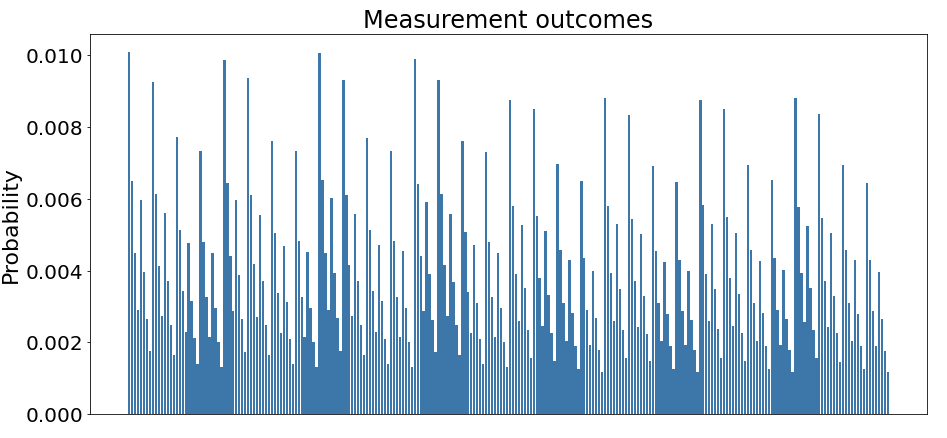
As we can see, the result of the algorithm is extremely noisy and running it wouldn't give much better results than trying out numbers at random. This is mostly due to the relatively high error rate of CNOTs and
environmental noise. This implementation does not take into account possible error correction schemes which could improve the accuracy of the algorithm. Of course, adding error correction would greatly increase the number of required qubits which current hardware can't afford. <br> <br>
Current quantum machines are clearly far from being able to do achieve things such as breaking the RSA 2048 encryption. However, technology advances quickly and companies such as IBM plan on building processors with thousands of qubits, perhaps even millions, this decade. According to some fairly recent estimates from [Craig Gidney and Martin Ekerå](https://arxiv.org/pdf/1905.09749.pdf) breaking RSA 2048 requires roughly 20 million qubits with similar error rates as we used in this notebook, but assuming error correction is implemented.